# Python Time Series Analysis 
This is a sample of Python code for conducting a Time-Series analysis of real sales data.  The model provides an analysis of the data, forecasts into the future, and checks the residuals. The data we are using comes from a well known distributor of wine in the United States.  the data is a randomly selected set of data from the total time period we had to use.  We're using this data in order to demonstrate SARIMAX, and also to maintain confidentiality of the data source.

In [28]:
#importing data for time series 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly as pl
import statsmodels
import statsmodels.api as sm
import itertools

In [29]:
#modules for time series analysis
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf

In [31]:
# Import the time series data
jc = 'jcdatapy.csv'
data = pd.read_csv(jc)
data.head()  #make sure it worked...

,Date,Sales,Intent,Spend
0,2016-04-01,74340.71,21.91,545664.31
1,2016-05-01,113533.76,18.88,607878.90
2,2016-06-01,140037.02,22.86,1396676.84
3,2016-07-01,69381.41,16.45,604576.71
4,2016-08-01,91231.26,22.04,50865.61


In the data set, the dependent variable is "Unit Sales", denoted in the file as "Sales.  We have an independent variable: "purchase intent", but we won't be using it for this analysis. 

First let's create a sequence plot of the Dependent Variable in order to check for stationarity.  In time series analysis, the data must be stationary before running the analysis.  Otherwise you risk detecting spuriou effects.

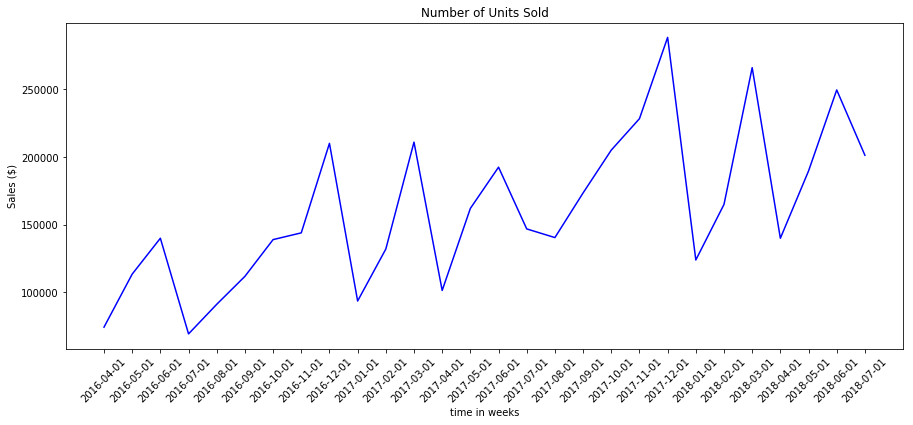

In [36]:
t = data['Date']
plt.plot(t, data['Sales'], 'b-')  #creates a plot of the DV
fig.autofmt_xdate()
fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.title('Number of Units Sold') #adds a title
plt.ylabel('Sales ($)') #adds a label to the y-axis
plt.xlabel('time in weeks') #adds a label to the x-axis
plt.xticks(rotation=45) # need to rotate the axis labels in order to read them! 
plt.show()

The sequence plot shows a small linear trend over time, but no obvious seasonality in the data.  In order to correct for the trend, we can take the first difference of the Sales variable.
Next, we plot the independent variable along the same axis to check for similarity.  Here, the variables are on different scales, so we need to create a sub-plot in the graph, and plot "intent" on a secondary axis.

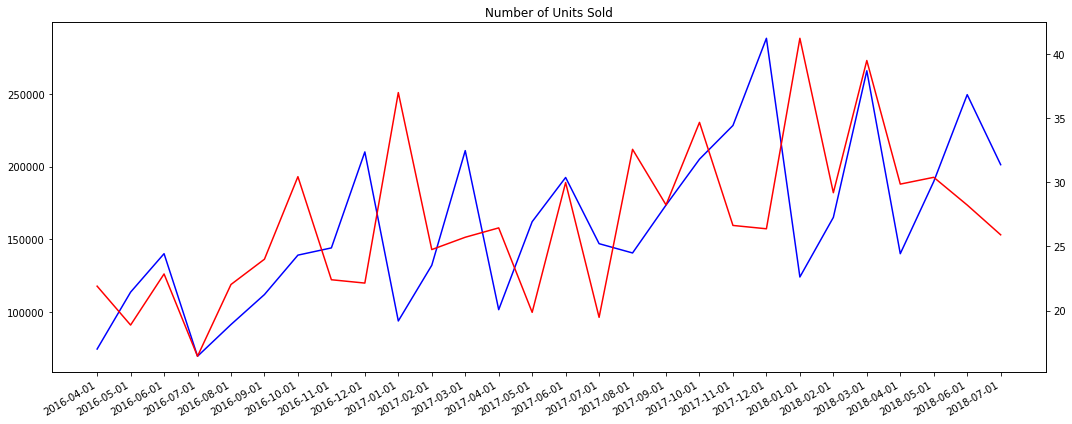

In [11]:
# Sequence plot assuming unequal scales
plt.close('all')
fig, ax1 = plt.subplots()
t = data['Date']
ax1.plot(t, data['Sales'], 'b-', label='Sales')
fig.autofmt_xdate()
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


ax2 = ax1.twinx()
ax2.plot(t, data['Intent'], 'r-', label = 'Intent')

plt.title('Number of Units Sold')
fig.tight_layout()
plt.show()


Here we're going to convert the data into TimeSeries format so we can perform Time Series operations on the dataset. Since this is a univariate Time Series Analysis, we do not need to worry about predictors. 

In [18]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')  #parse the time data into the correct format
data = pd.read_csv('jcdatapy.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse) #load the parsed data
data #check that it looks right
data.index #dtype must return datetime64[ns]

ts_sales = data['Sales']  #convert to univariate series object

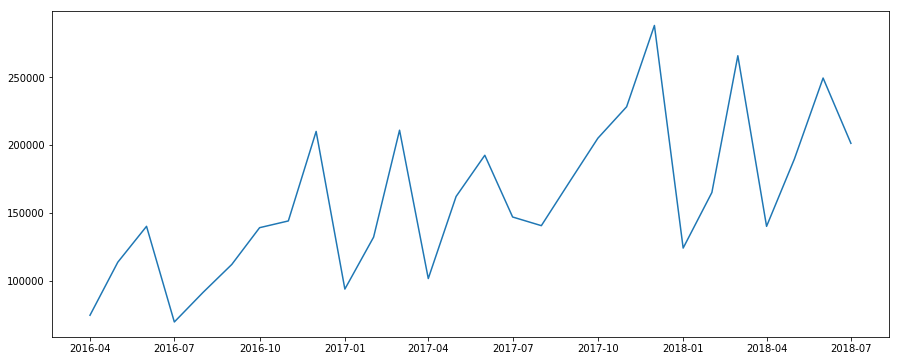

In [19]:
plt.plot(ts_sales)  #showing the univariate series now with converted Time format. 
plt.show()


Let's create a moving average to better visualize the trend in the data. 

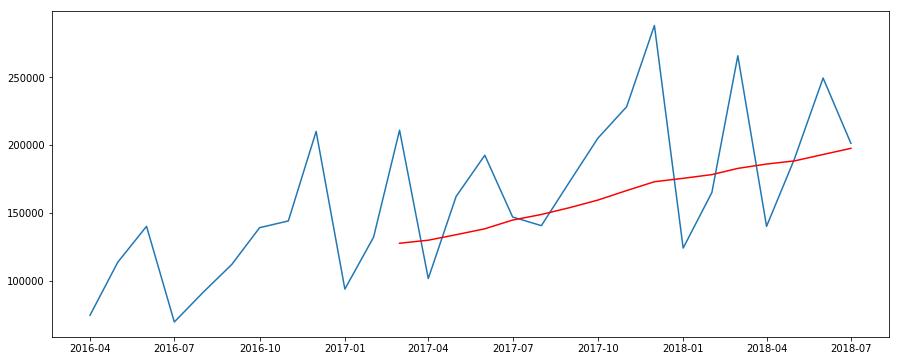

In [17]:
rolmean = ts_sales.rolling(12).mean()
plt.plot(ts_sales)
plt.plot(rolmean, color='red')
plt.show()

# Developing the Time Series Model
The code below fits the time series model to the Sales data.  Here we used SARIMAX simply to demonstrate how to write the code assuming a seasonal effect.  The code below generates the statespace model, assuming an auto-regressive seasonal effect.  We then forecast out 12 months. 

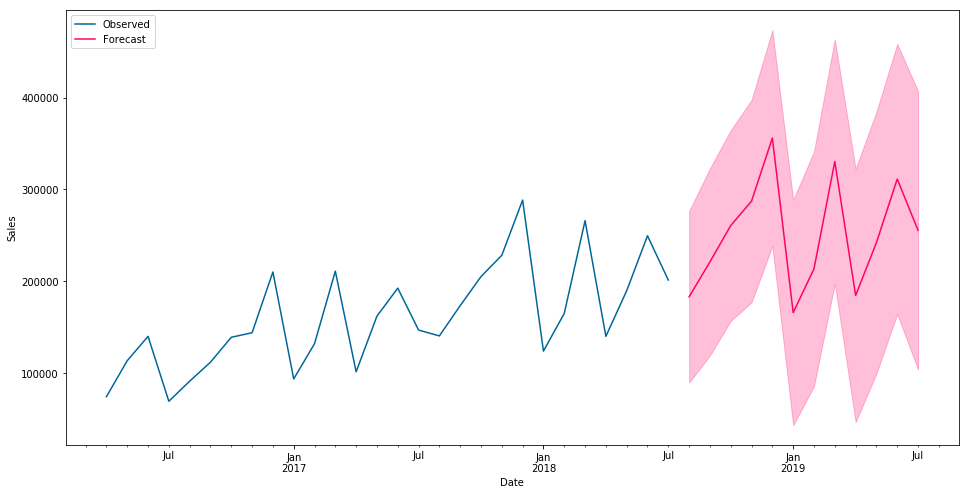

In [22]:
import warnings
warnings.filterwarnings('ignore')
y = data['Sales'] 

res = sm.tsa.statespace.SARIMAX(ts_sales, order=(2,1,1), seasonal_order=(1,0,0,12), enforce_stationarity=False, enforce_invertability=False).fit()

# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2016-04-01'), end=pd.to_datetime('2018-07-01'),dynamic=True)

#Get forecast 12 periods into the future
pred_uc = res.get_forecast(steps=12)

#Get Confidence Intervals of forecasts
pred_ci = pred_uc.conf_int()


#Plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Sales');
plt.legend(loc='upper left')
plt.show()

The graph above shows the Time Series analysis and the 12-month prediction forecast with 95% confidence intervals. The table summary below shows the model results.  As this is mostly for demonstration purposes, we're not that concerned about large errors, or non-significant results.   
AIC/BIC - normally, if we generated multiple models we would compare these and look for the lowest
Independent (auto-correlated regressors) - none of the auto-regressive or moving average lags were found to be statistically significant 
Ljung-Box - is not significant, indicating that there is no autocorrelation in the residuals. 

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   28
Model:             SARIMAX(2, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -152.710
Date:                            Wed, 14 Nov 2018   AIC                            315.419
Time:                                    18:43:20   BIC                            318.244
Sample:                                04-01-2016   HQIC                           314.839
                                     - 07-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1010      2.540     -0.040      0.968      -5.078       4.876
ar.L2         -0.2758      4.223   

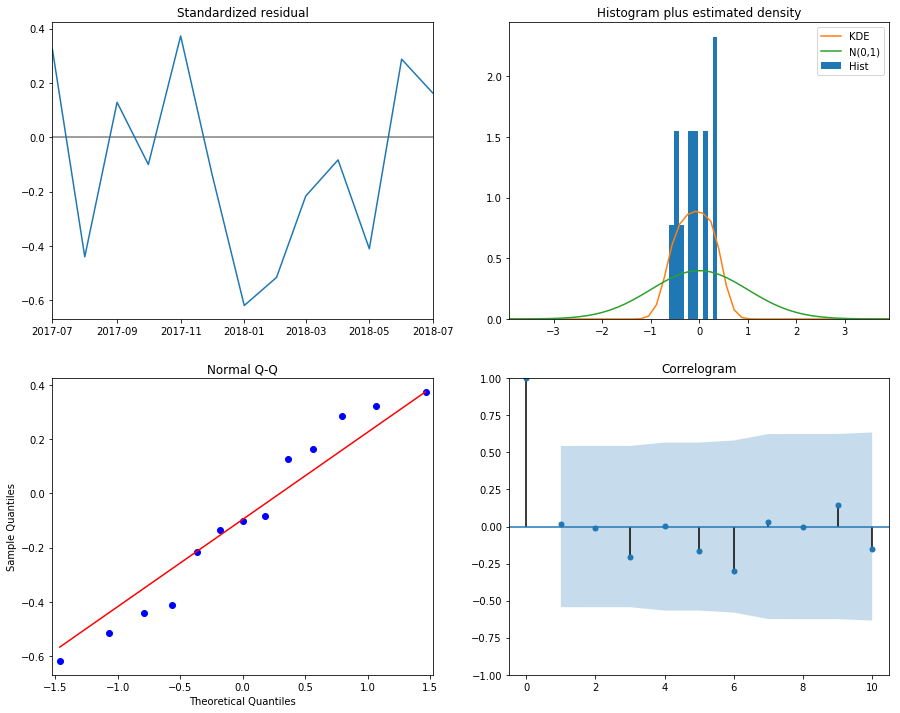

In [19]:
print(res.summary())
#print(ts_sales)
res.plot_diagnostics(figsize=(15,12))
plt.show()

In [23]:
pred = res.get_prediction(start=pd.to_datetime('2016-04-01'),dynamic=False)
pred_ci = pred.conf_int()

In [24]:
y_forecasted = pred.predicted_mean
y_truth = y
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1746572060.7
